In [1]:
import os
import scipy.io
from libs import util_matlab as umatlab
import tensorflow as tf
import numpy as np
import statistics, math
from libs import datasets, dataset_utils, utils
import datetime
import time
from matplotlib import pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

In [85]:
#resources_dir = "/Users/alfonso/code/violinDemos/ViolinTrainer/resources/MacMic_MyViolin/"
resources_dir = "/Users/alfonso/code/violinDemos/ViolinTrainer/resources/"
resource = [
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            'Scarlett_V1',
            'MacMic_MyViolin',
            'MacMic_MyViolin',
            'MacMic_MyViolin',
            'MacMic_V2',
            'MacMic_ViolinYamaha'
           ]
filenames = [
    ['BackNoiseMaia', 'EString_Long', 'AString_Long', 'DString_Long', 'GString_Long'],
    ['BackNoiseMaia', 'EStringScaleVibrato', 'AStringScaleVibrato', 'DStringScaleVibrato', 'GStringScaleVibrato'],
    ['BackNoiseMaia', 'EStringGliss', 'AStringGliss', 'DStringGliss', 'GStringGliss'],
    ['BackNoiseMaia', 'EStringScaleDetache', 'AStringScaleDetache', 'DStringScaleDetache', 'GStringScaleDetache'],
    ['Silence', 'EString', 'AString', 'DString', 'GString'],
    ['Silence01', 'EString01', 'AString01', 'DString01', 'GString01'],
    ['BackNoiseMaia', 'EStringScaleVibrato', 'AStringScaleVibrato', 'DStringScaleVibrato', 'GStringScaleVibrato'],
    ['BackNoiseMaia', 'EStringGliss', 'AStringGliss', 'DStringGliss', 'GStringGliss'],
    ['Silence', 'EString', 'AString', 'DString', 'GString'],
    ['Silence01', 'EString01', 'AString01', 'DString01', 'GString01'],
]
#filenames = ['BackNoiseMaia', 'EStringGliss', 'AStringGliss', 'DStringGliss', 'GStringGliss']
#['Silence01', 'EString01', 'AString01', 'DString01', 'GString01']
n_classes = 5
winLSecs = 0.1
energyBands_sr = 200
windowSize = int((winLSecs * energyBands_sr) // 2 * 2)
# And we'll move our window by windowSize/2
hopSize = windowSize // 2
hopSize

10

inputFile = resources_dir + resource[0] + "/" + filenames[0][1] + '.16bit-EnergyBankFilter.txt'
energy_bands_dB = np.loadtxt(inputFile, skiprows=0).T
print("input file:\n", inputFile)
print(energy_bands_dB)

energy_bands = 10**(energy_bands_dB/20)
rmsEnergy_dB=20*np.log10(np.sqrt(np.mean(energy_bands**2,0)))
plt.plot(rmsEnergy_dB)

In [86]:
# prepare dataset
# ------------- prepare dataset
addYamahaRecs = False
Xs = []
ys = []
[n_recordings, n_strings] = np.array(filenames).shape

for iRecording in range (0, n_recordings):
    for iString in range(0, n_strings):
        inputFile = resources_dir + resource[iRecording] + "/" + filenames[iRecording][iString] + '.16bit-EnergyBankFilter.txt'
        #print("reading File: ", inputFile)
        energy_bands_dB = np.loadtxt(inputFile, skiprows=0).T
        #energy_bands= (energy_bands /120 )+1 #normalize [0-1]
        energy_bands = 10**(energy_bands_dB/20)
        rmsEnergy_dB=20*np.log10(np.sqrt(np.mean(energy_bands**2,0)))
        target = np.ones(energy_bands.shape[1]) * (iString)
        energy_bands_norm= energy_bands_dB / rmsEnergy_dB
        energy_bands_norm = energy_bands_norm /4


        n_hops = (energy_bands.shape[1]) // hopSize
        n_hops = int(n_hops) - 1        #??
        for hop_i in range(n_hops):
            # Creating our sliding window
            frames = energy_bands_norm[:, (hop_i * hopSize):(hop_i * hopSize + windowSize)]
            avgString = round(statistics.median(target[(hop_i * hopSize):(hop_i * hopSize + windowSize)]))
            #if (avgString - target[hop_i * hopSize] == 0):  #take only windows in the same string
            Xs.append(frames[..., np.newaxis])
            ys.append(int(avgString))

print("Xs.shape:", np.array(Xs).shape, ", ys.shape:", np.array(ys).shape)

if addYamahaRecs == False:
    Xs = np.array(Xs)
    ys = np.array(ys)
    #ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], n_classes=0)
    ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], one_hot=True, n_classes=n_classes)

Xs.shape: (51387, 40, 20, 1) , ys.shape: (51387,)


In [67]:
n_hops

2415

In [68]:
#add Yamaha DB to the dataset
if addYamahaRecs:
    data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius/export"
    files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

    count = 0
    # Let's start with the music files
    for filename in files:
        #print(filename)
        matlabStruct=umatlab.loadmat(filename).get('data')
        energy_bands_dB = matlabStruct.get('energyBand') #/120)+1
        energy_bands = 10**(energy_bands_dB/20)
        rmsEnergy_dB=20*np.log10(np.sqrt(np.mean(energy_bands**2,0)))
        energy_bands_norm= energy_bands_dB / rmsEnergy_dB
        energy_bands_norm = energy_bands_norm /4

        controlData=matlabStruct.get('controlData')
        #controlNames=matlabStruct.get('controlNames')
        string=controlData[0,:]
        target=string

        if (count == 0):
            totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
            energyBands_sr=energy_bands_norm.shape[1]/totalSecs #This is around 100Hz-10ms
            #target_sr = target.shape[0]/totalSecs
            #IO_sr_ratio = energyBands_sr / target_sr
            winLSecs=0.05
            windowSize=int((winLSecs*energyBands_sr)//2*2)
            # And we'll move our window by 250 ms at a time
            hopSize=windowSize//2

        n_hops = (energy_bands_norm.shape[1]) // hopSize
        n_hops=int(n_hops)-1
        count = count +1

        for hop_i in range(n_hops):
            # Creating our sliding window
            b = (hop_i * hopSize)
            e = (hop_i * hopSize + windowSize)
            frames = energy_bands_norm[:,b:e]
            if(math.isnan(max(frames[:,1]))==False):
                avgString=round(statistics.median(string[b:e]))
                if (avgString-string[hop_i * hopSize]==0): #take only windows in the same string
                    Xs.append(frames[..., np.newaxis])
                    ys.append(int(avgString))
    Xs = np.array(Xs)
    ys = np.array(ys)
    print(Xs.shape, ys.shape)
    ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], one_hot=True, n_classes=n_classes)

In [87]:
# create convNet
# ---------- create ConvNet
tf.reset_default_graph()

X = tf.placeholder(name='X', shape=(None, Xs.shape[1], Xs.shape[2], Xs.shape[3]), dtype=tf.float32)
Y = tf.placeholder(name='Y', shape=(None, n_classes), dtype=tf.float32)

# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [20, 20, 20]

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    H, W = utils.conv2d(
        H, n_filters_i, k_h=2, k_w=2, d_h=2, d_w=2,
        name=str(layer_i))

    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.softplus(H)

    # Just to check what's happening:
    print(H.get_shape().as_list())

# Connect the last convolutional layer to a fully connected network
fc, W = utils.linear(H, n_output=100, name="fcn1", activation=tf.nn.relu)
# fc2, W = utils.linear(fc, n_output=50, name="fcn2", activation=tf.nn.relu)
# fc3, W = utils.linear(fc, n_output=10, name="fcn3", activation=tf.nn.relu)

# And another fully connceted network, now with just n_classes outputs, the number of outputs that our
# one hot encoding has
Y_pred, W = utils.linear(fc, n_output=n_classes, name="pred", activation=tf.nn.sigmoid)

[None, 20, 10, 20]
[None, 10, 5, 20]
[None, 5, 3, 20]


In [88]:
# pre-train ConvNet
loss = tf.squared_difference(Y_pred, Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y, 1)
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Explore these parameters: (TODO)
batch_size = 100

# Create a session and init!
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

In [90]:
# train ConvNet
# Now iterate over our dataset n_epoch times
n_epochs = 5000
# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    if epoch_i % 10 == 0:
        print('Epoch: ', epoch_i)
    # Train
    this_accuracy = 0
    its = 0
    accByString=[0]*5
    itsByString=[0]*5
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        [batch_prediction, batch_accuracy, _] = sess.run([Y_pred, accuracy, optimizer], feed_dict={
            X: Xs_i, Y: ys_i})
        #compute accuracy for each string
        this_accuracy += batch_accuracy
        #compute accuracy for each string
        origString = np.argmax(ys_i,1)
        predString= np.argmax(batch_prediction,1)
        for iString in range(5):
            idx = np.where(origString==iString)
            idx=idx[0]
            if len(idx):
                sumByString=np.sum(np.equal(origString[idx],predString[idx]).astype(float))
                accByString[iString]+=sumByString
                itsByString[iString]+=len(idx)
        its += 1
        #print("minibatch.train:",its)
    if epoch_i % 10 == 0:
        print('Training accuracy: ', this_accuracy, '/', its, '=', this_accuracy/its)
        for iString in range(5):
            print("accByString[", iString, "]:", accByString[iString],'/',itsByString[iString],
                 '=', accByString[iString]/itsByString[iString])

    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0

    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_accuracy += sess.run(accuracy, feed_dict={
            X: Xs_i, Y: ys_i})
        its += 1
        #print("minibatch.valid:",its)
    if epoch_i % 10 == 0:
        print('Validation accuracy: ', this_accuracy, '/', its, '=', this_accuracy/its)

Epoch:  0
Training accuracy:  372.400000215 / 412 = 0.903883495666
accByString[ 0 ]: 6390.0 / 6452 = 0.990390576565
accByString[ 1 ]: 7584.0 / 8357 = 0.907502692354
accByString[ 2 ]: 6712.0 / 8225 = 0.816048632219
accByString[ 3 ]: 7602.0 / 8670 = 0.876816608997
accByString[ 4 ]: 8889.0 / 9406 = 0.945035083989
Validation accuracy:  46.4317949414 / 52 = 0.892919133489
Epoch:  10
Training accuracy:  381.37000078 / 412 = 0.925655341698
accByString[ 0 ]: 6418.0 / 6452 = 0.994730316181
accByString[ 1 ]: 7680.0 / 8357 = 0.918990068206
accByString[ 2 ]: 6962.0 / 8225 = 0.846443768997
accByString[ 3 ]: 7883.0 / 8670 = 0.9092272203
accByString[ 4 ]: 9104.0 / 9406 = 0.967892834361
Validation accuracy:  47.8887180686 / 52 = 0.920936885935
Epoch:  20
Training accuracy:  387.470000625 / 412 = 0.940461166565
accByString[ 0 ]: 6428.0 / 6452 = 0.996280223187
accByString[ 1 ]: 7806.0 / 8357 = 0.934067249013
accByString[ 2 ]: 7192.0 / 8225 = 0.874407294833
accByString[ 3 ]: 8062.0 / 8670 = 0.92987312572

KeyboardInterrupt: 

In [43]:
#check predictions
# Do our mini batches:
Xs_i, ys_i = next(ds.train.next_batch(400))
prediction = sess.run([Y_pred], feed_dict={X:Xs_i})[0]

<IPython.core.display.Javascript object>


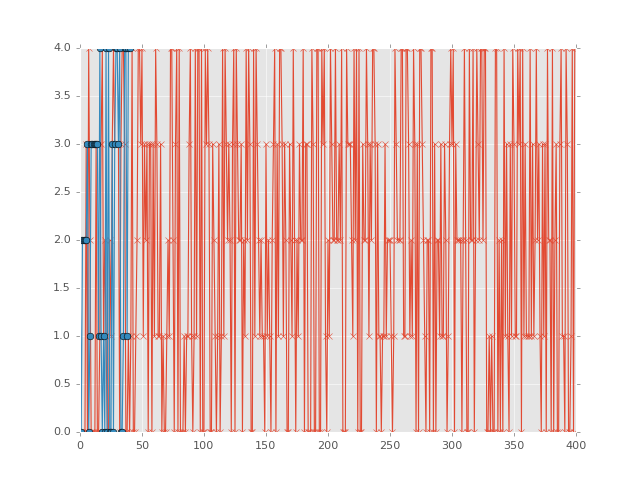

In [44]:
plt.plot(np.argmax(prediction,1),'x-')
plt.plot(np.argmax(ys_i,1),'o-')

In [91]:
# post-train ConvNet
now = datetime.datetime.now()
save_path = saver.save(sess, "./models/string_convnet_" + "all_hopmixed_convHop10"+ "_" + now.strftime("%Y%m%d_%H%M") + ".ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: ./models/string_convnet_all_hopmixed_convHop10_20170506_1638.ckpt


### A partir de aqui leemos del fichero salvado y testeamos...

In [ ]:
plt.plot(energy_bands)
plt.title('String-{}'.format(iString))